In [ ]:
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, t_train), (x_test, t_test) = fashion_mnist.load_data()

2.14.0
4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
print(x_train.shape)

(60000, 28, 28)


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from drive.MyDrive.common.optimizer import *
from drive.MyDrive.common.functions import *
from drive.MyDrive.common.layers import *
from collections import OrderedDict
from drive.MyDrive.common.gradient import *
from drive.MyDrive.common.trainer import *

In [ ]:
class Sigmoid: #import 해온 곳에 얘가 없어서 추가로 작성
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

class MLP: #가중치 감소, 드롭아웃, 배치 정규화 구현 교재코드를 기초함
    """
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    use_dropout : 드롭아웃 사용 여부
    dropout_ration : 드롭아웃 비율
    use_batchNorm : 배치 정규화 사용 여부
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0,
                 use_dropout = False, dropout_ration = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])

            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ration)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화

        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg=False):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, X, T):
        Y = self.predict(X, train_flg=False)
        Y = np.argmax(Y, axis=1)
        if T.ndim != 1 : T = np.argmax(T, axis=1)

        accuracy = np.sum(Y == T) / float(X.shape[0])
        return accuracy

    def numerical_gradient(self, X, T):
        """
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(X, T, train_flg=True)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = numerical_gradient(loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(loss_W, self.params['beta' + str(idx)])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads

In [ ]:
#학습 시 전체데이터 안쓰는 방안도 있다고해서 구현은 해두었으나 성능이 좋은지는 모르겠어서 꺼놨습니다
#x_train = x_train[:1000]
#t_train = t_train[:1000]

#하이퍼하라미터 수정존
iters_num = 100_000
batch_size = 100
epochs = 10
learning_rate = 0.002 # 0.01
hidden_size_list = [169,100,50] #[100,100] [100,50,50]
use_batchnorm = True
use_dropout= True
dropout_ratio = 0.3 # 0.2 ~ 0.5
activation='relu' # 'sigmoid' #'relu'
weight_init_std='he' #'xavier' #'he'

network = MLP(input_size=784,
                                  hidden_size_list=hidden_size_list,
                                  output_size=10,
                                  weight_init_std=weight_init_std,
                                  activation=activation,
                                use_batchnorm=use_batchnorm,
                                use_dropout=use_dropout)
optimizers = Adam(lr=learning_rate)

train_size = x_train.shape[0]; train_loss_list = [] ; test_acc_list = [] ;train_acc_list = []
iter_per_epoch = max(train_size / batch_size, 1) ; count = 0

In [ ]:
for i in range(iters_num):
    #미니배치
    batch_mask = np.random.choice(train_size, batch_size)

    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 오차역전파
    grad = network.gradient(x_batch, t_batch)

    #매개변수 재조정
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    #아담
    optimizers.update(network.params, grad)


    if count == epochs:
        break

    if i % iter_per_epoch == 0:
        # Calculate training accuracy
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        loss = network.loss(x_train, t_train) #(x_batch, t_batch)
        train_loss_list.append(loss)


        print(f"Epoch {int(i/iter_per_epoch)}, Loss: {loss:.2f}, Train Acc: {train_acc:.2%} ,Test Acc: {test_acc:.2%}")
        count = count + 1

IndexError: ignored

**하이퍼파라미터 최적화**

In [ ]:
# 데이터셋 셔플
#from util import shuffle_dataset
#x_train, t_train = shuffle_dataset(x_train, t_train)

# 20%를 검증 데이터로 분할
validation_rate = 0.20 #1 2,000개
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

In [ ]:
x_train.shape


(48000, 28, 28)

val acc:0.8803333333333333 | lr:0.00025796064994617994, weight decay:7.100684695549126e-07
val acc:0.37966666666666665 | lr:5.1822987319783086e-05, weight decay:1.1365611782159755e-07


/content/drive/MyDrive/common/functions.py:56: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size


val acc:0.864 | lr:0.001751534256743907, weight decay:2.4470326793127286e-05
val acc:0.8846666666666667 | lr:0.0003520184723504047, weight decay:3.0370613083898043e-05
val acc:0.777 | lr:9.590635954649578e-05, weight decay:1.3654601543898521e-05
val acc:0.29791666666666666 | lr:5.406484421223305e-06, weight decay:2.5963139248394404e-07
val acc:0.8319166666666666 | lr:9.634625261056856e-05, weight decay:8.570129126076765e-06
val acc:0.7556666666666667 | lr:0.00010792088980279768, weight decay:4.1800085076357665e-08
val acc:0.8890833333333333 | lr:0.0022706988213727418, weight decay:3.2380381137344214e-07
val acc:0.28258333333333335 | lr:1.5944595308520358e-06, weight decay:1.1634578993077017e-07
val acc:0.2815 | lr:1.0431437170870948e-06, weight decay:1.953207489740739e-07
val acc:0.8833333333333333 | lr:0.0011658593468595055, weight decay:2.882423834516296e-06
val acc:0.8855 | lr:0.0005114654322066446, weight decay:6.91524328477542e-08
val acc:0.5000833333333333 | lr:1.2450955040562686

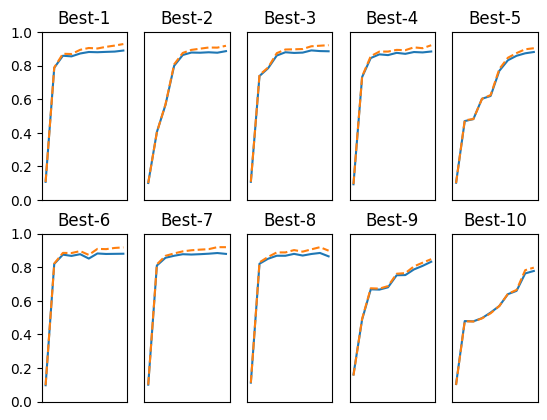

In [ ]:
def __train(lr, weight_decay, epocs=10):
    network = MLP(input_size=784,
                                  hidden_size_list=hidden_size_list,
                                  output_size=10,
                                  weight_init_std=weight_decay,
                                  activation='relu',
                                use_batchnorm=True,
                                use_dropout=False)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=200,
                      optimizer='Adam',
                      optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 20
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 10
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x: x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5:
        plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

In [ ]:
# 구한 최적의 하이퍼파라미터 적용

In [ ]:
#Best-1(val acc:0.8890833333333333) | lr:0.0022706988213727418, weight decay:3.2380381137344214e-07
#Best-2(val acc:0.8855) | lr:0.0005114654322066446, weight decay:6.91524328477542e-08
# val acc:0.852 | lr:0.001215906743865886, weight decay:4.1176003391955446e-08

In [ ]:
(x_train, t_train), (x_test, t_test) = fashion_mnist.load_data()

In [ ]:
iters_num = 10000
batch_size = 200
epochs = 30
learning_rate = 0.001215906743865886
hidden_size_list = [100,50,25] #[100,100] [100,50,50]
use_batchnorm = True
use_dropout= False
dropout_ratio = 0.3 # 0.2 ~ 0.5
activation='relu' # 'sigmoid' #'relu'
weight_init_std=4.1176003391955446e-08

network = MLP(input_size=784,
                                  hidden_size_list=hidden_size_list,
                                  output_size=10,
                                  weight_init_std=weight_init_std,
                                  activation=activation,
                                use_batchnorm=use_batchnorm,
                                use_dropout=use_dropout)
optimizers = Adam(lr=learning_rate)

train_size = x_train.shape[0]; train_loss_list = [] ; test_acc_list = [] ;train_acc_list = []
iter_per_epoch = max(train_size / batch_size, 1) ; count = 0

In [1]:
# val acc:0.852 | lr:0.001215906743865886, weight decay:4.1176003391955446e-08

for i in range(iters_num):
    #미니배치
    batch_mask = np.random.choice(train_size, batch_size)

    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 오차역전파
    grad = network.gradient(x_batch, t_batch)

    #매개변수 재조정
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    #아담
    optimizers.update(network.params, grad)

    if i % iter_per_epoch == 0:
        # Calculate training accuracy
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        loss = network.loss(x_batch, t_batch) #(x_batch, t_batch)
        train_loss_list.append(loss)


        print(f"Epoch {int(i/iter_per_epoch)}, Loss: {loss:.2f}, Train Acc: {train_acc:.2%} ,Test Acc: {test_acc:.2%}")
        count += 1  # Increment count here

        if count == epochs:
            break

NameError: ignored